In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [4]:
def grille_sauts(T, kn,lamda):
    jumps_t = []
    grid = []
    x =  np.random.exponential(lamda)
    sum_x = x
    
    vec = []
    t = 0
    vec.append(t)
    vec.append(0)
    grid.append(vec)
    vec = []
    
    # construction of the jump times
    while sum_x < T:
        jumps_t.append(sum_x)
        x = np.random.exponential(lamda)
        sum_x += x
    
    i = 0
    # construction of the grid on the interval [0,last jump]
    jump_size = len(jumps_t)
    epsilon = 0
    while t < T and i < jump_size:
        epsilon = 0
        t = min(t + 1.0/kn, jumps_t[i])
        if t == jumps_t[i]:
            i += 1
            epsilon = 1 # it is a jump time
        
        vec.append(t)
        vec.append(epsilon)
        grid.append(vec)
        
        vec = []
    
    # to construct the grid on the inverval ]last jump, T]
    while t < T:
        t += 1.0/kn
        
        vec.append(t)
        vec.append(0) # epsilon = 0
        grid.append(vec)
        
        vec = []
    
    vec = []
    vec.append(T)
    vec.append(0)
    
    if grid[-1][0] < T:
        grid.append(vec)
    
    if grid[-1][0] > T:
        grid.pop()
        grid.append(vec)
    
    return grid


In [5]:
import math
import random

def k_n(theta_n, bn, c, w_n):
    if min(theta_n / (bn ** 2), math.sqrt(theta_n) / c) >= w_n:
        return 1
    else:
        return max(bn ** 2 * w_n, (c * w_n) ** 2)

def inverted_h_premiere_mesure_infinie(u, alpha, theta_n, un):
    if u < 1 / 2:
        return -((2 * u) ** (-1 / alpha)) / un
    else:
        return ((2 - alpha * theta_n * u / un ** alpha) ** (-1 / alpha)) / un

def inverted_h_seconde_mesure_infinie(u, alpha, theta_n, un):
    if u < (1 / (alpha * theta_n)) * (un ** alpha - 1):
        return -((alpha * theta_n * u + 1) ** (-1 / alpha))
    else:
        return ((-alpha * theta_n * u + 2 * un ** alpha - 1) ** (-1 / alpha))

In [6]:
def diff_x_y(M, x0, T, kn, un, c, bn, alpha, theta_n, wn):
    results = []
    grid = []
    x = x0
    y = x0
    h = 0
    saut = 0
    var_norm = 0
    w = 0
    grid_taille = 0
    
    for j in range(1, M):
        h = 0
        saut = 0
        x = x0
        grid.clear()
        grid = grille_sauts(T, kn, theta_n)
        grid_taille = len(grid)
        
        for i in range(1, grid_taille):
            z=np.random.normal(0, 1)
            u=np.random.uniform(0,1)
            h = grid[i][0] - grid[i-1][0]
            var_norm = z * math.sqrt(c * h)
            x = x *np.exp( bn * h + var_norm)
            w += var_norm
            if grid[i][1] != 0:
                #saut=inverted_h_premiere_mesure_infinie(u, alpha, theta_n, un)
                saut =inverted_h_seconde_mesure_infinie(u, alpha, theta_n, un)
                x = x * (1 + saut)
                y = y * (1 + saut)
                
        results.append(wn * (y * math.exp(bn - c / 2 + w) - x))
    
    return results


def seconde_methode(M, kn, un, alpha, theta_n, wn,lamda):
    results = []
    interm = wn*math.sqrt(min(1/theta_n,1/kn))
    x, nombre_de_saut = 1, 0
    for j in range(1,M):
        nombre_de_saut = np.random.poisson(lamda)
        x = 1
        for i in range(1,nombre_de_saut):
            z=np.random.normal(0, 1)
            u=np.random.uniform(0,1)
            #x=x*(1 + inverted_h_premiere_mesure_infinie(u, alpha, theta_n, un))
            x = x * (1 + inverted_h_seconde_mesure_infinie(u, alpha, theta_n, un))
        results.append(interm*x)
    return results

def diff_esperance_x_y(M, x0, T, kn, un, c, bn, alpha, wn, uN, theta_N):
    #expo = lambda t: np.exp(-theta_n*t)
    #var_poisson = lambda: np.random.poisson(theta_N/T)

    sum1, sum2 = 0, 0
    sqrtc = math.sqrt(c)
   # interm = np.exp(bn-c/2)

    for j in range(1,M):
        x = x0
        nombre_de_saut = np.random.poisson(1/theta_N)
        #print(nombre_de_saut)
        z=np.random.normal(0, 1)
        for i in range(1,nombre_de_saut):
            
            u=np.random.uniform(0,1)
            #x=x*(1 + inverted_h_premiere_mesure_infinie(u, alpha, theta_N, uN))
            x = x * (1 + inverted_h_seconde_mesure_infinie(u, alpha, theta_N, uN))
        sum1 += x*np.exp(bn-c/2+sqrtc*z)

    sum1 = sum1/M
    #print(sum1)
    for j in range(1,M):
        h, saut, x = 0, 0, x0
        grid = grille_sauts(T, kn, theta_N)
        grid_taille = len(grid)

        for i in range(1,grid_taille):
            z=np.random.normal(0, 1)
            u=np.random.uniform(0,1)
            h = grid[i][0] - grid[i-1][0]
            x = x * np.exp( (bn-c/2) * h + z * math.sqrt(c * h))
            if (grid[i][1] != 0):
                saut =  inverted_h_seconde_mesure_infinie(u, alpha, theta_N, uN)
                #saut =  inverted_h_premiere_mesure_infinie(u, alpha, theta_N, uN)
                x = x * (1 + saut)
        sum2 += x

    sum2 = sum2/M
    #print(sum2)
    return wn*(sum1-sum2)

def plusieurs_diff_esperance_x_y(M, x0, T, c, bn, alpha, uN):
    results = []
    for un in range(1,uN,500):
        z=np.random.normal(0, 1)
        u=np.random.uniform(0,1)
        theta_n2 = (2*pow(un,alpha)-1)/alpha
        wn2 = (pow(2*pow(un,alpha-2)/(2-alpha),-1/2))
        kn2 = k_n(theta_n2, bn, c, wn2)
        results.append(diff_esperance_x_y(M, x0, T, kn2, un, c, bn, alpha, wn2, uN, theta_n2))
    return results


In [20]:
M = 100000 # Number of paths
x0 = 100  # Spot
T = 1
uN = pow(10, 4)
alpha_1 = 1.5
alpha_2 = 1.8
bn = 1
c = 1
theta_N_1 = (2 * pow(uN, alpha_1)) / alpha_1
wN_1 = np.sqrt((2 - alpha_1) / 2) * pow(uN, (2 - alpha_1) / 2)
theta_N_2 = (2* pow(uN, alpha_2) - 1) / alpha_2
wN_2 = pow(2 * pow(uN, alpha_2 - 2) / (2 - alpha_2), -1 / 2)
kN_1 = k_n(theta_N_1, bn, c, wN_1)
kN_2 = k_n(theta_N_2, bn, c, wN_2)
lamda=4
strike = 120
kn = 1000

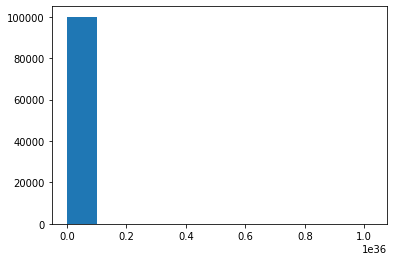

In [21]:
plt.hist(diff_x_y(M, x0, T, kN_2, uN, c, bn, alpha_2, theta_N_2, wN_2))
plt.show()

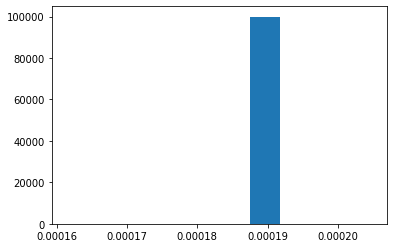

In [22]:
plt.hist(seconde_methode(M, kN_2, uN, alpha_2, theta_N_2, wN_2,lamda))
plt.show()

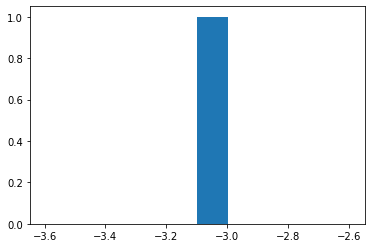

In [23]:
plt.hist(diff_esperance_x_y(M, x0, T, kN_2, uN, c, bn, alpha_2, wN_2, uN, theta_N_2))
plt.show()

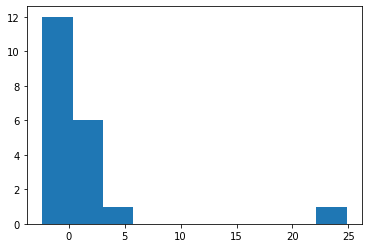

In [25]:
plt.hist(plusieurs_diff_esperance_x_y(M, x0, T, c, bn, alpha_2, uN))
plt.show()